# CineFeel_Phase_2.Face_clustering

In [ ]:
# === 셀 1: 노트북 제목 및 설명 ===
# @title 🎭 CineFeel Face Clustering Pipeline
# @markdown 이 노트북은 탐지된 얼굴들을 인물별로 분류하고 라벨링합니다.
# @markdown


import os
import sys
from pathlib import Path

print("🎭 CineFeel Face Clustering Pipeline")
print("=" * 50)

🎭 CineFeel Face Clustering Pipeline


# 🔧 객체 탐지 환경 설치

In [ ]:
# @title 🎭 Face Clustering 의존성 설치
# @markdown 필요한 라이브러리들을 지정된 버전으로 설치합니다.
!pip install \
    "numpy>=1.21.0,<2.0.0" \
    "tensorflow==2.12.0" \
    "deepface>=0.0.90" \
    "networkx>=3.0,<4.0.0" \
    "scikit-learn>=1.3.0,<1.5.0" \
    "opencv-python>=4.8.0,<5.0.0" \
    "matplotlib>=3.5.0" \
    "Pillow>=8.0.0" \
    "tqdm>=4.65.0" \
    "pandas>=1.5.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This

# GPU 및 시스템 정보 확인

In [ ]:
# === 셀 4: GPU 및 시스템 정보 확인 ===
# @title ��️ GPU 및 시스템 정보 확인

import tensorflow as tf
import torch
import platform
import psutil

print(" 시스템 정보:")
print(f"  OS: {platform.system()} {platform.release()}")
print(f"  Python: {platform.python_version()}")
print(f"  총 메모리: {psutil.virtual_memory().total / 1e9:.1f}GB")
print(f"  사용 가능: {psutil.virtual_memory().available / 1e9:.1f}GB")

print("\nGPU 정보:")
# TensorFlow GPU
tf_gpus = tf.config.list_physical_devices('GPU')
print(f"  TensorFlow GPU: {len(tf_gpus)}개")
for i, gpu in enumerate(tf_gpus):
    print(f"    GPU {i}: {gpu.name}")

# PyTorch GPU
print(f"  PyTorch GPU 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  PyTorch GPU 모델: {torch.cuda.get_device_name(0)}")
    print(f"  PyTorch GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")

# DeepFace GPU 확인
try:
    from deepface import DeepFace
    print("  ✅ DeepFace 설치 완료")
except:
    print("  ❌ DeepFace 설치 실패")

 시스템 정보:
  OS: Linux 6.1.143+
  Python: 3.11.13
  총 메모리: 16.8GB
  사용 가능: 13.2GB

GPU 정보:
  TensorFlow GPU: 0개
  PyTorch GPU 사용 가능: True
  PyTorch GPU 모델: NVIDIA L4
  PyTorch GPU 메모리: 23.7GB
25-08-05 02:11:13 - Directory /root/.deepface has been created
25-08-05 02:11:13 - Directory /root/.deepface/weights has been created
  ✅ DeepFace 설치 완료


# ⚙️ 파이프라인 설정

이 셀의 변수들을 수정하여 파이프라인을 설정하세요. 모든 경로는 이 셀에서 관리됩니다.

# 데이터 확인

In [ ]:
# prompt: 얼굴 데이터 분석에 필요한 상수들을 정의. 버킷에서 가져올 데이터 소스의 주소, 분류에 사용할 모델의 설정값, 분석후 데이터를 저장할 내용 등 위 내용 참고. ArcFace모델 사용

# --- 1. Google Cloud 설정 ---
PROJECT_ID = 'sesac-ljj0210'
GCS_BUCKET_NAME = 'sesac-ljj-20250715'
GCS_PROJECT_PATH = 'pjt_cinefeel'


# --- 2. 입력 데이터 경로 ---
GCS_SOURCE_DATA_PATH = "" # 분석할 데이터 파일 경로
LOCAL_DATA_PATH = "/tmp/" # 데이터를 다운로드할 로컬 경로

# --- 3. 모델 및 처리 설정 ---
ARCFACE_MODEL = "ArcFace" # 사용할 얼굴 인식 모델
ARCFACE_CONFIG = { # 모델에 전달할 추가 설정
    'detector_backend': 'mtcnn', # 얼굴 감지 백엔드
    'distance_metric': 'cosine' # 클러스터링에 사용할 거리 측정 방식
}

# 클러스터링 유사도 임계값. 이 값보다 거리가 가까우면 같은 인물로 간주합니다.
# ArcFace와 cosine 거리를 사용할 때 일반적으로 0.4 ~ 0.6 사이의 값을 사용합니다.
SIMILARITY_THRESHOLD = 0.3

# --- 4. 출력 데이터 경로 ---
LOCAL_RESULT_DIR = "/tmp/results" # 결과를 저장할 로컬 디렉토리
GCS_RESULT_PATH = f"gs://{GCS_BUCKET_NAME}/{GCS_PROJECT_PATH}/src/face_clustering/result" # 결과 파일을 업로드할 GCS 경로

print("✅ Configuration Loaded")
print(f"PROJECT_ID: {PROJECT_ID}")
print(f"LOCAL_RESULT_DIR: {LOCAL_RESULT_DIR}")

print("✅ Constants Defined")

✅ Configuration Loaded
PROJECT_ID: sesac-ljj0210
LOCAL_RESULT_DIR: /tmp/results
✅ Constants Defined


In [ ]:
import os
import subprocess
import re
from datetime import datetime, timedelta

def get_latest_file_from_gcs(bucket_name, project_path, subfolder, file_extension=".zip"):
    """
    GCS 버킷에서 특정 하위 폴더에 있는 가장 최근 파일의 경로를 가져옵니다.

    Args:
        bucket_name (str): GCS 버킷 이름.
        project_path (str): GCS 프로젝트 경로.
        subfolder (str): 하위 폴더 경로.
        file_extension (str, optional): 가져올 파일의 확장자. 기본값은 ".zip".

    Returns:
        str: 가장 최근 파일의 GCS 경로. 파일이 없으면 None을 반환합니다.
    """

    try:
        # gsutil ls 명령어를 사용하여 파일 목록 가져오기
        gcs_path = f"gs://{bucket_name}/{project_path}/{subfolder}/**{file_extension}"
        process = subprocess.run(['gsutil', 'ls', '-l', gcs_path], capture_output=True, text=True, check=True)
        files = process.stdout.strip().split('\n')

        # 파일 목록이 비어있거나, "TOTAL" 라인만 있는 경우 필터링
        valid_files = [line for line in files if line.strip() and 'TOTAL' not in line]
        if not valid_files:
            print(f"No files found at path: {gcs_path}")
            return None

        # 파일 목록에서 파일 이름과 시간 정보 추출
        file_info = []
        for file_str in valid_files:
            # 정규식을 사용하여 타임스탬프와 전체 GCS 경로를 추출합니다.
            match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z)\s+(gs://.*)', file_str)
            if match:
                time_str, full_gcs_path = match.groups()
                file_time = datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%SZ")
                file_info.append((full_gcs_path, file_time))

        # 가장 최근 파일 찾기
        if file_info:
            latest_file_path = max(file_info, key=lambda x: x[1])[0]
            return latest_file_path
        else:
            return None

    except subprocess.CalledProcessError as e:
        # gsutil이 파일을 찾지 못하면 오류를 반환하므로, 이를 정상적인 케이스로 처리합니다.
        if "matched no objects" in e.stderr:
            print(f"No files found at path: {gcs_path}")
        else:
            print(f"Error listing files in GCS: {e.stderr}")
        return None

# --- 분석할 데이터 경로 설정 ---
# GCS_SOURCE_DATA_ZIP_PATH = get_latest_file_from_gcs(GCS_BUCKET_NAME, GCS_PROJECT_PATH, "src/object_detection/result")
GCS_SOURCE_DATA_ZIP_PATH = "gs://sesac-ljj-20250715/pjt_cinefeel/src/object_detection/result/Arcface_20250805_012909_resolution_1440p.zip"

if GCS_SOURCE_DATA_ZIP_PATH:
    print(f"분석할 데이터 경로: {GCS_SOURCE_DATA_ZIP_PATH}")
else:
    print("분석할 데이터가 없습니다.")

분석할 데이터 경로: gs://sesac-ljj-20250715/pjt_cinefeel/src/object_detection/result/Arcface_20250805_012909_resolution_1440p.zip


Copying gs://sesac-ljj-20250715/pjt_cinefeel/src/object_detection/result/Arcface_20250805_012909_resolution_1440p.zip...
/ [1 files][  5.5 MiB/  5.5 MiB]                                                
Operation completed over 1 objects/5.5 MiB.                                      
✅ 데이터 다운로드 완료: /tmp/Arcface_20250805_012909_resolution_1440p.zip
✅ 압축 해제 완료: /tmp/results
✅ 이미지 파일 개수: 661


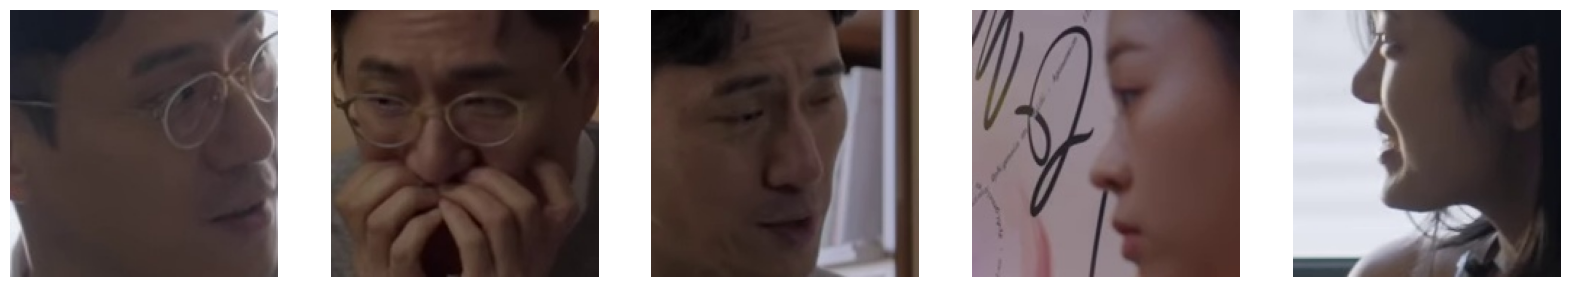

In [ ]:
import os
import zipfile
from shutil import rmtree
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- 데이터 다운로드 및 압축 해제 ---
if GCS_SOURCE_DATA_ZIP_PATH:
    # GCS 경로에서 파일 이름을 추출하여 로컬 파일 경로를 구성합니다.
    local_zip_filename = os.path.basename(GCS_SOURCE_DATA_ZIP_PATH)
    local_zip_filepath = os.path.join(LOCAL_DATA_PATH, local_zip_filename)

    print(f"Downloading {GCS_SOURCE_DATA_ZIP_PATH} to {local_zip_filepath}...")
    !gsutil cp "{GCS_SOURCE_DATA_ZIP_PATH}" "{local_zip_filepath}"

    # 파일이 성공적으로 다운로드되었는지 확인합니다.
    if not os.path.exists(local_zip_filepath):
        print(f"❌ 파일 다운로드 실패: {local_zip_filepath}")
    else:
        print(f"✅ 데이터 다운로드 완료: {local_zip_filepath}")

        # --- 압축 해제 ---
        if os.path.exists(LOCAL_RESULT_DIR):
            rmtree(LOCAL_RESULT_DIR)  # 기존 결과 폴더 삭제

        os.makedirs(LOCAL_RESULT_DIR, exist_ok=True)
        # 디렉토리가 아닌, 다운로드된 zip 파일의 정확한 경로를 사용합니다.
        with zipfile.ZipFile(local_zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(LOCAL_RESULT_DIR)
        print(f"✅ 압축 해제 완료: {LOCAL_RESULT_DIR}")

        # --- 분류를 위한 데이터셋 ---
        image_paths = []
        unzipped_files = os.listdir(LOCAL_RESULT_DIR)
        # 압축 해제된 폴더 안에 실제 이미지 파일이 있을 수 있으므로 모든 하위 파일을 검색합니다.
        for root, _, files in os.walk(LOCAL_RESULT_DIR):
            for filename in files:
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(root, filename))

        print(f"✅ 이미지 파일 개수: {len(image_paths)}")

        # --- 이미지 미리보기 (선택) ---
        if image_paths:
            fig, axes = plt.subplots(1, min(5, len(image_paths)), figsize=(20, 4))  # 최대 5개 이미지 미리보기
            for i, img_path in enumerate(image_paths[:5]):
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(img)
                    axes[i].axis('off')
                except Exception as e:
                    print(f"이미지 로드 오류 {img_path}: {e}")
            plt.show()
else:
    print("❌ 분석할 데이터 경로(GCS_SOURCE_DATA_ZIP_PATH)가 설정되지 않았습니다.")

# 얼굴 클러스터링 실시

✅ 이미지 파일 개수: 661


얼굴 임베딩 추출:   0%|          | 0/661 [00:00<?, ?it/s]

✅ 661개의 얼굴 임베딩 추출 완료.
📊 그래프 기반 클러스터링 시작...
👥 15개의 클러스터(인물) 발견.


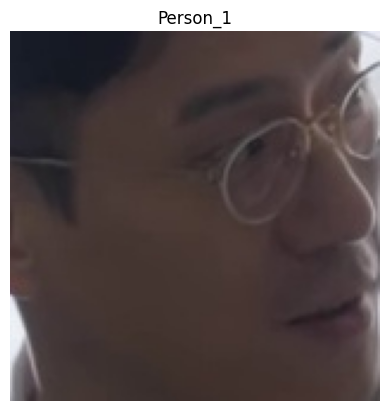

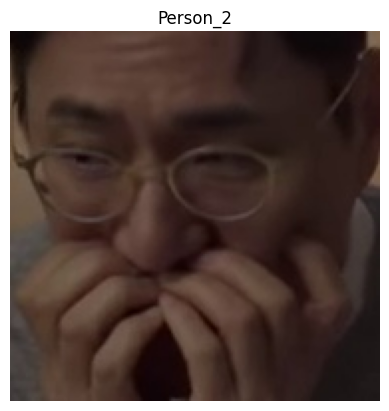

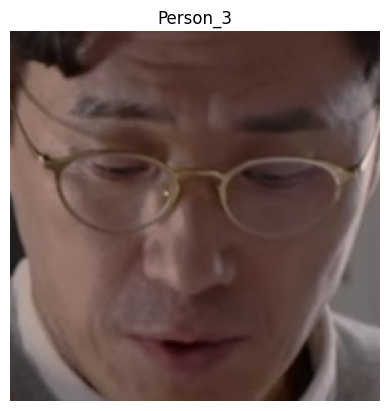

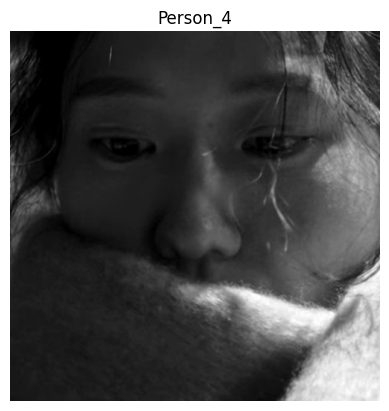

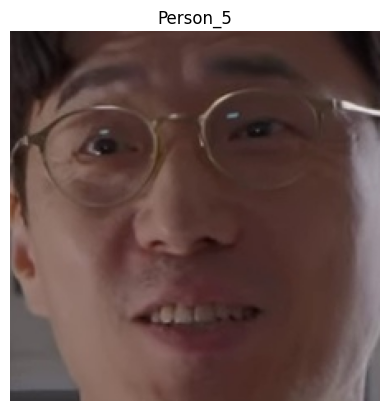

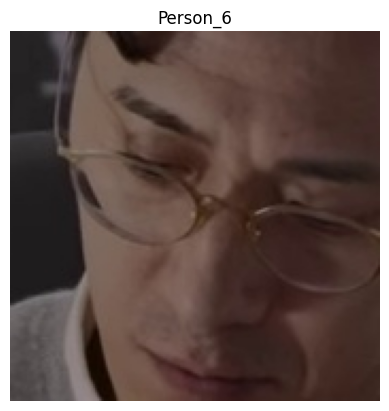

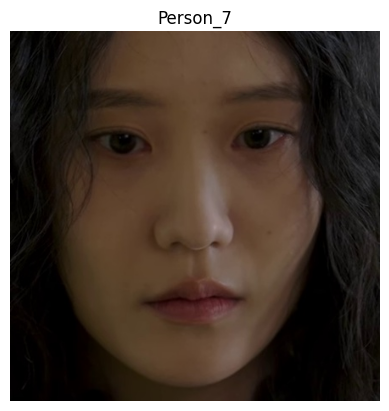

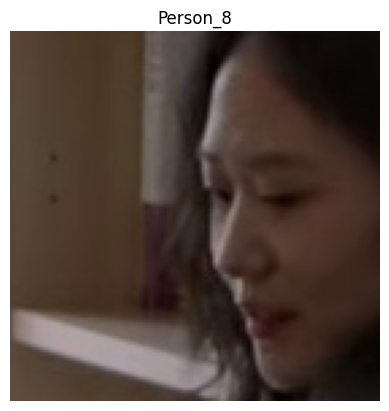

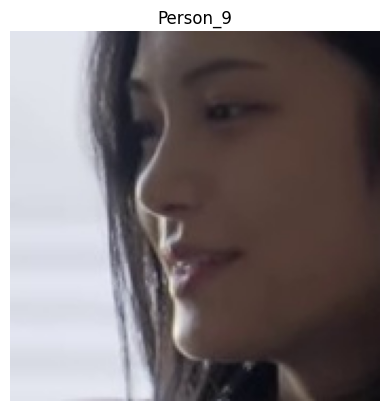

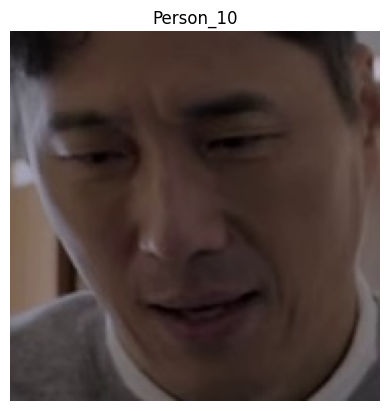

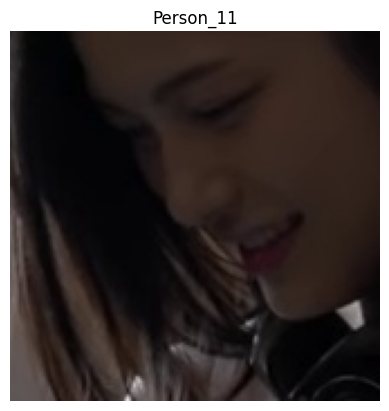

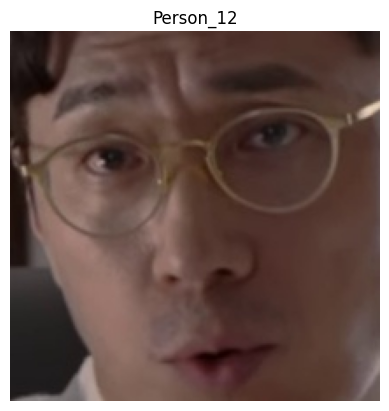

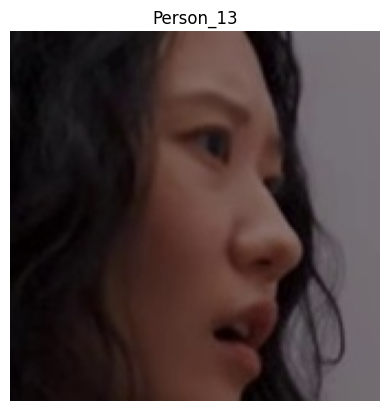

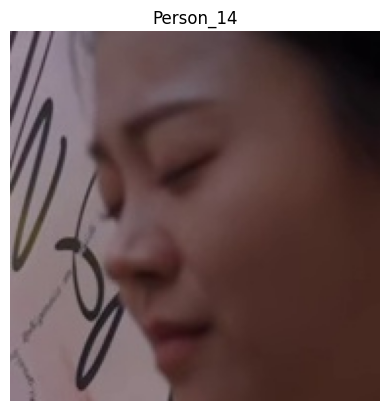

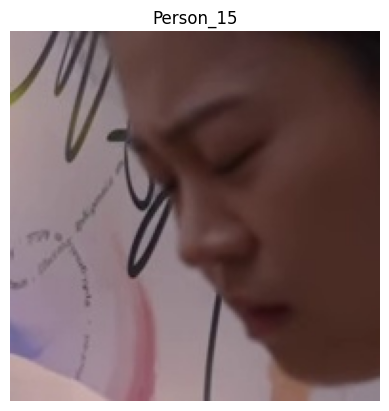

In [ ]:
import os
import shutil
import networkx as nx
from deepface import DeepFace
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial.distance import pdist, squareform

# --- 얼굴 임베딩 추출 및 클러스터링 ---
if 'image_paths' in locals() and image_paths:
    print(f"✅ 이미지 파일 개수: {len(image_paths)}")

    embeddings_data = []
    for img_path in tqdm(image_paths, desc="얼굴 임베딩 추출"):
        try:
            # DeepFace.represent는 감지된 각 얼굴에 대한 딕셔너리 리스트를 반환합니다.
            embedding_objs = DeepFace.represent(
                img_path,
                model_name=ARCFACE_MODEL,
                enforce_detection=False,
                detector_backend=ARCFACE_CONFIG.get('detector_backend', 'mtcnn')
            )
            # 이미지에 얼굴이 여러 개 있을 수 있으므로 첫 번째 감지된 얼굴의 임베딩을 사용합니다.
            if embedding_objs and 'embedding' in embedding_objs[0]:
                embeddings_data.append({
                    "path": img_path,
                    "embedding": embedding_objs[0]['embedding']
                })
        except Exception as e:
            print(f"이미지 임베딩 추출 오류 {img_path}: {e}")

    df = pd.DataFrame(embeddings_data)

    if not df.empty:
        print(f"✅ {len(df)}개의 얼굴 임베딩 추출 완료.")

        # --- 그래프 기반 클러스터링 ---
        print("📊 그래프 기반 클러스터링 시작...")
        embeddings = np.array(df['embedding'].tolist())

        # 코사인 거리 행렬 계산 (임베딩 간의 거리 측정)
        distance_matrix = squareform(pdist(embeddings, metric=ARCFACE_CONFIG.get('distance_metric', 'cosine')))

        # 임계값 기반으로 그래프 생성
        G = nx.Graph()
        for i in range(len(df)):
            for j in range(i + 1, len(df)):
                if distance_matrix[i, j] < SIMILARITY_THRESHOLD:
                    G.add_edge(i, j)

        # 연결된 컴포넌트(클러스터) 찾기
        clusters = list(nx.connected_components(G))
        print(f"👥 {len(clusters)}개의 클러스터(인물) 발견.")

        # 데이터프레임에 클러스터 ID 할당
        df['cluster'] = -1  # -1은 노이즈(클러스터링되지 않음)를 의미
        for cluster_id, component in enumerate(clusters):
            for node_idx in component:
                df.loc[node_idx, 'cluster'] = cluster_id

        # --- 인물별 대표 사진 출력 및 저장 ---
        clustered_output_dir = os.path.join(LOCAL_RESULT_DIR, "clustered_faces")
        if os.path.exists(clustered_output_dir):
            shutil.rmtree(clustered_output_dir)
        os.makedirs(clustered_output_dir, exist_ok=True)

        for cluster_id, group in df.groupby("cluster"):
            if cluster_id == -1:
                continue

            # 각 클러스터의 첫 번째 이미지를 대표 이미지로 선택
            representative_image_path = group.iloc[0]['path']
            img = cv2.imread(representative_image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            person_label = f"Person_{cluster_id + 1}"
            plt.figure()
            plt.imshow(img)
            plt.title(person_label)
            plt.axis('off')

            # 대표 이미지 파일로 저장
            save_path = os.path.join(clustered_output_dir, f"{person_label}_representative.jpg")
            plt.savefig(save_path)
            plt.show()

            # 해당 클러스터에 속한 모든 이미지 복사
            cluster_person_dir = os.path.join(clustered_output_dir, person_label)
            os.makedirs(cluster_person_dir, exist_ok=True)
            for _, row in group.iterrows():
                shutil.copy(row['path'], cluster_person_dir)

    else:
        print("❌ 임베딩 추출 결과가 없어 클러스터링을 진행할 수 없습니다.")
else:
    print("❌ 이미지 경로가 없습니다.")

In [ ]:
# prompt: 생성된 결과물들을 zip으로 만들어 버킷에 저장. 저장되는 압축파일명은 사용된 모델명_timestamp

import os
import zipfile
from datetime import datetime

# --- 결과물 압축 및 GCS 업로드 ---
if 'clustered_output_dir' in locals() and os.path.exists(clustered_output_dir):
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    zip_filename = f"{ARCFACE_MODEL}_{timestamp}.zip"
    local_zip_filepath = os.path.join(LOCAL_RESULT_DIR, zip_filename)

    with zipfile.ZipFile(local_zip_filepath, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(clustered_output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), clustered_output_dir))

    print(f"✅ 결과물 압축 완료: {local_zip_filepath}")

    gcs_upload_path = os.path.join(GCS_RESULT_PATH, zip_filename)
    !gsutil cp "{local_zip_filepath}" "{gcs_upload_path}"
    print(f"✅ GCS 업로드 완료: {gcs_upload_path}")

else:
    print("❌ 클러스터링 결과 폴더가 없어 압축 및 업로드를 진행할 수 없습니다.")

✅ 결과물 압축 완료: /tmp/results/ArcFace_20250805053232.zip
Copying file:///tmp/results/ArcFace_20250805053232.zip [Content-Type=application/zip]...
/ [1 files][  5.5 MiB/  5.5 MiB]                                                
Operation completed over 1 objects/5.5 MiB.                                      
✅ GCS 업로드 완료: gs://sesac-ljj-20250715/pjt_cinefeel/src/face_clustering/result/ArcFace_20250805053232.zip


✅ 분류된 총 얼굴 개수: 661

👥 사람별 이미지 개수:
  Person_1: 581개
  Person_2: 3개
  Person_3: 15개
  Person_4: 5개
  Person_5: 8개
  Person_6: 5개
  Person_7: 3개
  Person_8: 3개
  Person_9: 2개
  Person_10: 2개
  Person_11: 2개
  Person_12: 7개
  Person_13: 2개
  Person_14: 4개
  Person_15: 2개


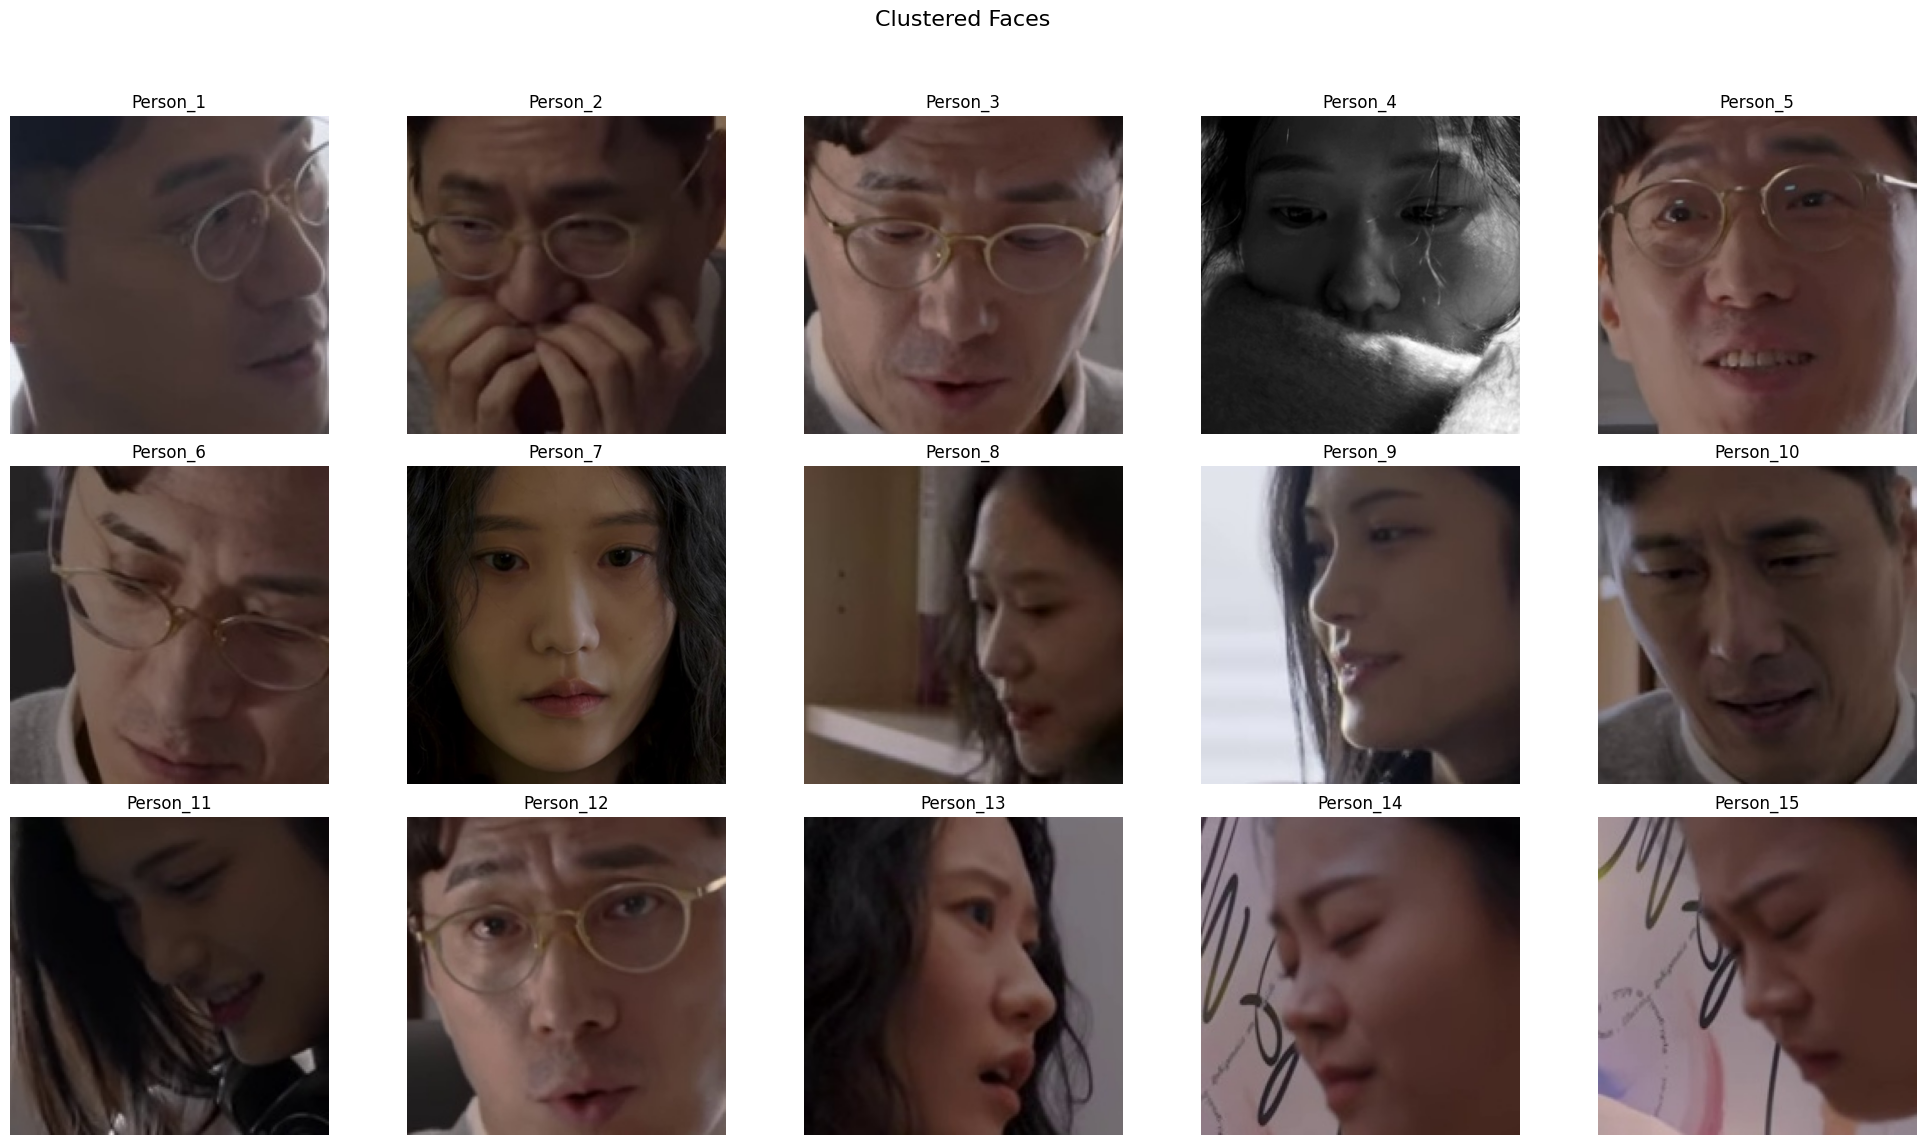

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

# --- 결과 분석 ---
if 'df' in locals() and not df.empty:
    total_faces = len(df)
    print(f"✅ 분류된 총 얼굴 개수: {total_faces}")

    # 사람별 이미지 개수 출력
    print("\n👥 사람별 이미지 개수:")
    # 노이즈(-1)를 제외하고 클러스터 ID를 오름차순으로 정렬
    valid_clusters = sorted([c for c in df['cluster'].unique() if c != -1])
    for cluster_id in valid_clusters:
        person_label = f"Person_{cluster_id + 1}"
        count = len(df[df['cluster'] == cluster_id])
        print(f"  {person_label}: {count}개")

    # --- Subplot을 활용한 시각화 ---
    clustered_output_dir = os.path.join(LOCAL_RESULT_DIR, "clustered_faces")
    if os.path.exists(clustered_output_dir):
        n_clusters = len(valid_clusters)
        if n_clusters > 0: # 클러스터가 존재하는 경우에만 시각화 진행
            n_cols = 5  # subplot의 열 개수
            n_rows = (n_clusters + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), squeeze=False)
            fig.suptitle("Clustered Faces", fontsize=16)

            # axes 배열을 1차원으로 만들어 쉽게 순회하고, 남는 공간 처리
            axes_flat = axes.flatten()

            for i, cluster_id in enumerate(valid_clusters):
                person_label = f"Person_{cluster_id + 1}"
                # 각 클러스터의 첫 번째 이미지를 대표 이미지로 사용
                representative_image_path = df[df['cluster'] == cluster_id].iloc[0]['path']
                try:
                    img = cv2.imread(representative_image_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes_flat[i].imshow(img)
                    axes_flat[i].set_title(person_label)
                    axes_flat[i].axis('off')
                except Exception as e:
                    print(f"이미지 로드 오류 {representative_image_path}: {e}")

            # 사용되지 않은 나머지 subplot 숨기기
            for i in range(n_clusters, len(axes_flat)):
                axes_flat[i].axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 제목과 subplot 간 간격 조정
            plt.show()

        else:
            print("❌ 클러스터가 존재하지 않습니다.")
    else:
        print("❌ 클러스터링 결과 폴더가 없습니다.")

else:
    print("❌ 데이터프레임이 없거나 비어 있습니다.")